## Import Libraries

In [172]:
import numpy as np 
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from warnings import simplefilter
simplefilter("ignore")

## Import the Dataset

In [173]:
import statsmodels.api as sm
data = sm.datasets.co2.load_pandas().data
df = data.copy()
df.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [174]:
df["Time"] = np.arange(len(data.index))
df = df.dropna()
df["co2"].isna().sum()


0

## Mapping of the Dataset

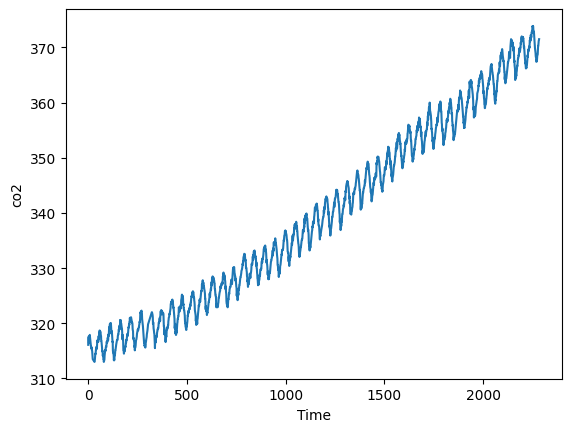

In [175]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(df,x="Time",y="co2")
plt.show()

## Building a Linear Regression Model

### Define Features & Labels and fit the Model

In [176]:
from sklearn.linear_model import LinearRegression

X = df.loc[:, ['Time']]  
y = df.loc[:, 'co2']

model = LinearRegression()
model.fit(X, y)
y_pred = pd.Series(model.predict(X), index=df.index)


### Visualize the Model compared to the Real Values

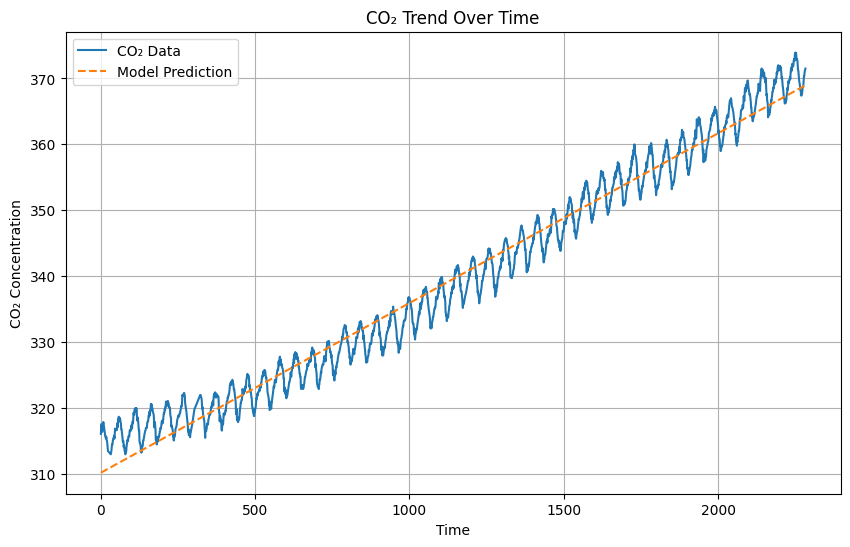

In [177]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df["Time"], df["co2"], label="CO₂ Data")
plt.plot(df["Time"], y_pred, linestyle="--", label="Model Prediction")
plt.xlabel("Time")
plt.ylabel("CO₂ Concentration")
plt.title("CO₂ Trend Over Time")
plt.legend()
plt.grid(True)

plt.show()


## Builiding Lag

### Shifting the dataset

In [178]:
df['Lag_1'] = df['Time'].shift(10)
df.head()

,co2,Time,Lag_1
1958-03-29,316.1,0,NaN
1958-04-05,317.3,1,NaN
1958-04-12,317.6,2,NaN
1958-04-19,317.5,3,NaN
1958-04-26,316.4,4,NaN


In [179]:
X = df[['Lag_1']].dropna()
y = df['co2'].loc[X.index]

### Training a Regression model

In [180]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

### Visualization of the model

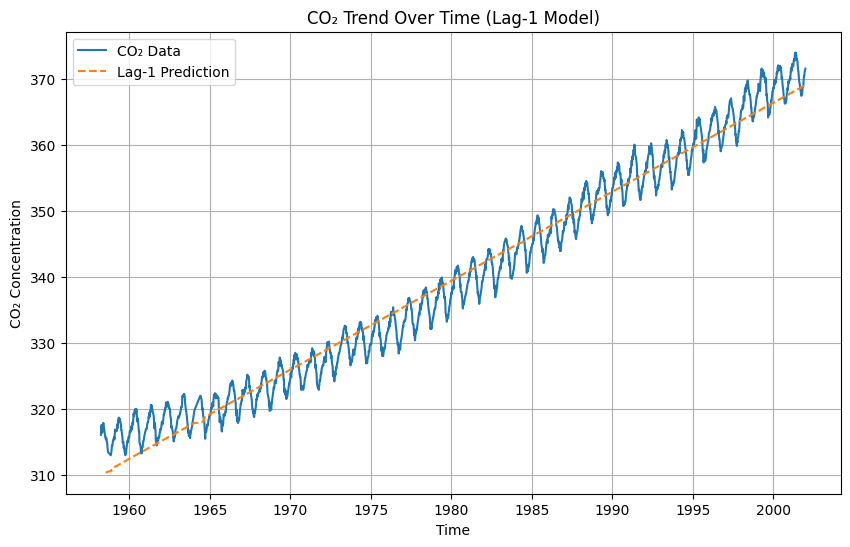

In [181]:
plt.figure(figsize=(10, 6))

plt.plot(df.index, df["co2"], label="CO₂ Data")  
plt.plot(y_pred.index, y_pred, linestyle="--", label="Lag-1 Prediction")

plt.xlabel("Time")
plt.ylabel("CO₂ Concentration")
plt.title("CO₂ Trend Over Time (Lag-1 Model)")
plt.legend()
plt.grid(True)
plt.show()


## Trends

### Moving Average

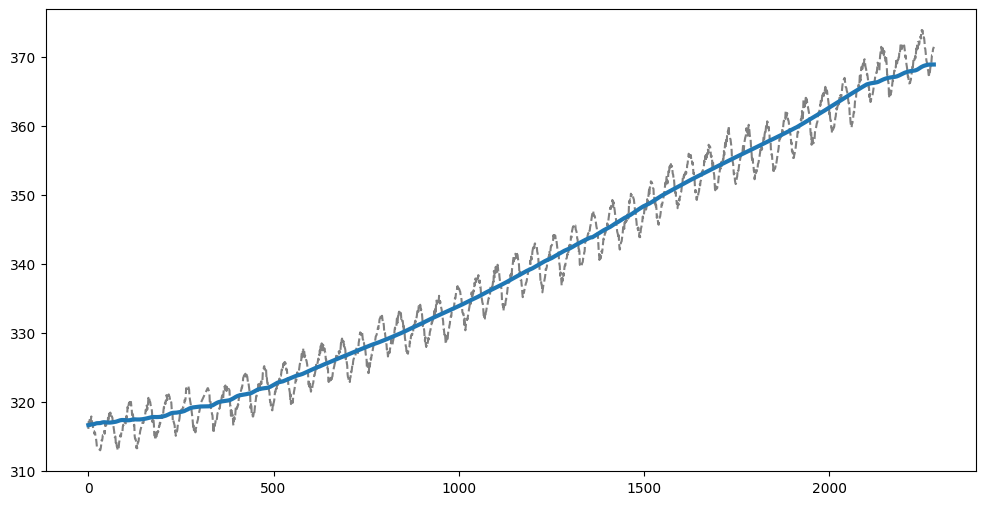

In [182]:
moving_average = df["co2"].rolling(
    window = 365,
    center = True,
    min_periods = 100
).mean()
plt.figure(figsize=(12, 6))
plt.plot(df["Time"], df["co2"], "--", color="0.5", label="CO₂ Data")
plt.plot(df["Time"], moving_average, linewidth=3, label="Moving Average")

### Preparing Time Matrix

In [183]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=df["Time"],
    constant=True,
    order=10,          
    drop=True
)
X = dp.in_sample()
y = df["co2"]
model = LinearRegression(fit_intercept=False)
model.fit(X, y[:len(X)]) 
y_pred = pd.Series(model.predict(X), index=X.index)



### Visualization of the Trend-fitted Model

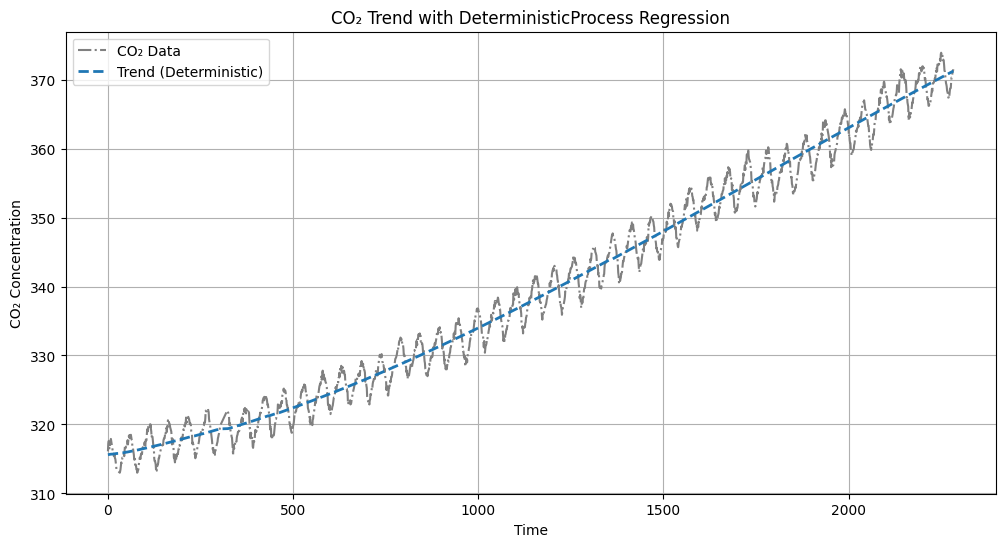

In [184]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(df["Time"], df["co2"], "-.", color="0.5", label="CO₂ Data")

plt.plot(df["Time"], y_pred, linewidth=2, linestyle="--", label="Trend (Deterministic)")

plt.xlabel("Time")
plt.ylabel("CO₂ Concentration")
plt.title("CO₂ Trend with DeterministicProcess Regression")
plt.legend()
plt.grid(True)
plt.show()


## Forecasting Values

### Cretae a new Dataset

In [185]:
X_fore = dp.out_of_sample(steps=50)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)
start = df["Time"].max() + 1
end   = start + len(y_fore)
y_fore.index = range(start, end)


In [186]:
print(f"X tail:{y_fore.tail()}")
print(f"df tail:{df.tail()}")

X tail:2329    372.534580
2330    372.562444
2331    372.590300
2332    372.618148
2333    372.645988
dtype: float64
df tail:              co2  Time   Lag_1
2001-12-01  370.3  2279  2269.0
2001-12-08  370.8  2280  2270.0
2001-12-15  371.2  2281  2271.0
2001-12-22  371.3  2282  2272.0
2001-12-29  371.5  2283  2273.0


### Visualization of the forecasted Values

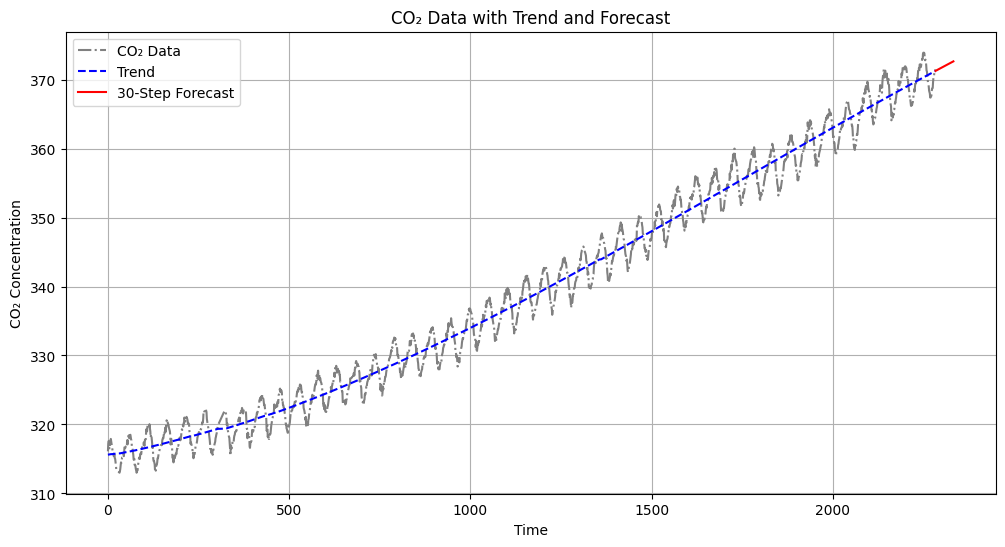

In [187]:
plt.figure(figsize=(12, 6))
plt.plot(df["Time"], df["co2"], "-.", color="0.5", label="CO₂ Data")
plt.plot(y_pred.index, y_pred, "--", color="blue", label="Trend")
plt.plot(y_fore.index, y_fore.values, "-", color="red", label="30-Step Forecast")
plt.xlabel("Time")
plt.ylabel("CO₂ Concentration")
plt.title("CO₂ Data with Trend and Forecast")
plt.legend()
plt.grid(True)
plt.show()

## Seasonality

### Prepare time series regression matrix

In [194]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

df.index = pd.to_datetime(df.index)

df = df.asfreq("W-SAT")

df["co2"] = df["co2"].interpolate()

fourier = CalendarFourier(freq="W", order=10)

dp = DeterministicProcess(
    index=df.index,
    constant=True,
    order=4,
    seasonal=True,
    additional_terms=[fourier],
    drop=True
)

X = dp.in_sample()


In [195]:
X.head()

,const,trend,trend_squared,trend_cubed,trend**4,"s(2,52)","s(3,52)","s(4,52)","s(5,52)","s(6,52)",...,"s(41,52)","s(42,52)","s(43,52)","s(44,52)","s(45,52)","s(46,52)","s(47,52)","s(48,52)","s(49,52)","s(50,52)"
1958-03-29,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1958-04-05,1.0,2.0,4.0,8.0,16.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1958-04-12,1.0,3.0,9.0,27.0,81.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1958-04-19,1.0,4.0,16.0,64.0,256.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1958-04-26,1.0,5.0,25.0,125.0,625.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Forecasting Values

In [196]:
y = df["co2"]
model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

In [197]:
y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

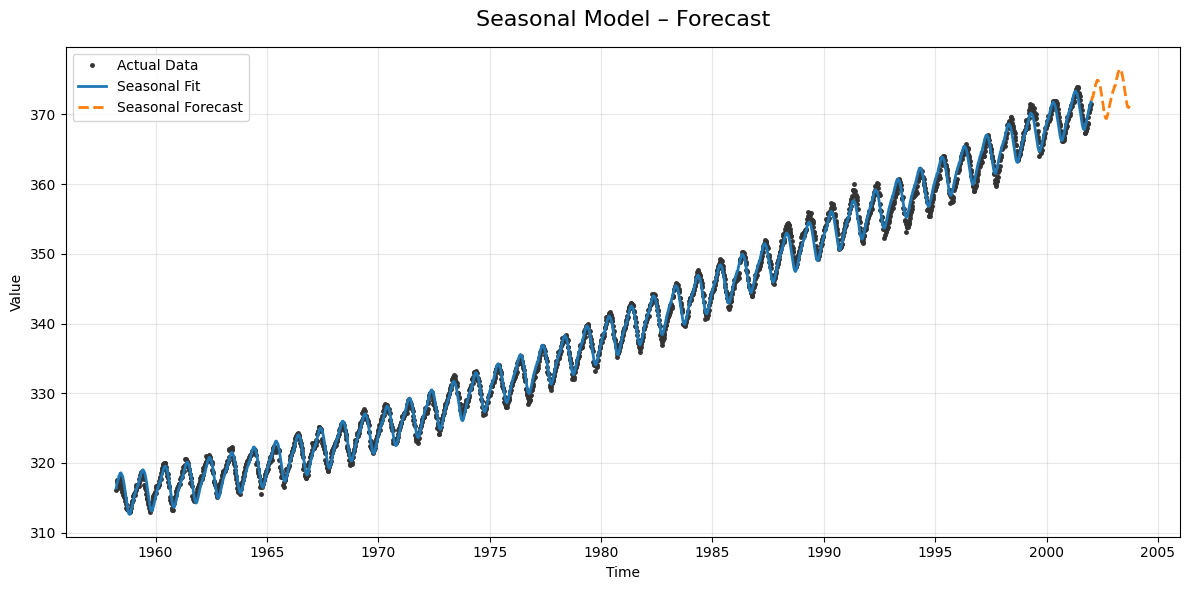

In [198]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(
    y.index, y.values,
    linestyle="none", marker=".", markersize=5,
    color="0.20", label="Actual Data"
)
ax.plot(
    y_pred.index, y_pred.values,
    linewidth=2,
    label="Seasonal Fit"
)
ax.plot(
    y_fore.index, y_fore.values,
    linewidth=2,
    linestyle="--",
    label="Seasonal Forecast",
)
ax.set_title("Seasonal Model – Forecast", fontsize=16, pad=15)
ax.set_xlabel("Time")
ax.set_ylabel("Value")

ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()
